# Score compression of pre-compressed (mean of batches) data with susequent neural density estimation

In [1]:
import numpy as np
import sys
# load your pydelfi version here (not necessary to include path if you have pip installed)
sys.path.append("/home/nessa/Documents/Projects/pydelfi/") 
import ndes.ndes as ndes
import delfi.delfi as delfi
import compression.score.score as score
import distributions.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

### load the data

In [2]:
# load Jia's data (note that order of params is not the same as data_sim)
fn       = np.loadtxt('./data/MassiveNuS_params.txt',usecols=[0],dtype=np.str)
params   = np.loadtxt('./data/MassiveNuS_params.txt',usecols=[1,2,3])## M_nu,Omega_m,A_s*1e9
data_sim = np.array([np.load('./data/%s_Peaks_KN_s2.00_z1.00_ng40.00_b050.npy'%(ifn))[2:] for ifn in fn])

In [3]:
# get parameters in correct order

def paramsFromName(fn):
    Om=float(fn.split('Om')[1].split('_')[0])
    As=float(fn.split('As')[1].split('_')[0])
    mnv=float(fn.split('mva')[1].split('_')[0])
    mnv+=float(fn.split('mvb')[1].split('_')[0])
    mnv+=float(fn.split('mvc')[1].split('_')[0])
    return mnv,Om,As


PARAMS = [paramsFromName(f) for f in fn]

In [4]:
# 101 cosmologies
print(params.shape)
num_c = params.shape[0]
# 9999 sims per comsology
print(data_sim.shape)
num_sims = data_sim.shape[1]
print(num_c,num_sims)

(101, 3)
(101, 9999, 50)
101 9999


In [5]:
# fiducial parameters (for compression)
index = 51
theta_fiducial = params[index]
print(theta_fiducial)


[0.1 0.3 2.1]


In [6]:
# bin centers of peak count bins
bin_centers = np.linspace(-1.92,5.92, 50)
# normalization factor
dk = 0.00126899073531

In [7]:
data_sim[0,0]*dk

array([ 0.,  0.,  1.,  0.,  0.,  2.,  1.,  3.,  4.,  1., 10., 16., 12.,
       21., 20., 27., 38., 47., 49., 36., 26., 27., 20., 31., 24., 27.,
       22., 15.,  8., 18., 10.,  5.,  5.,  3.,  4.,  2.,  1.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

### Precompression

In [8]:
#this is a precompression step, which can be replaced or not done. If we do it, we need to also redefine the covariance, accordingly
#Here, I average over batches of sims 

averaged_all   = np.zeros((num_c,np.int(num_sims/101),50))
for ii in range(num_c):
    for jj in range(np.int(num_sims/101)):
        averaged_all[ii,jj]=np.mean(data_sim[ii,jj*101:(jj+1)*101,:],axis=0)
    
averaged_all.shape

(101, 99, 50)

In [9]:
print(averaged_all[0,-1])

[2.34067669e+01 7.80225562e+01 1.87254135e+02 2.41869924e+02
 4.36926315e+02 6.31982705e+02 1.08451353e+03 1.89594812e+03
 2.59034887e+03 3.63585112e+03 5.97652781e+03 7.26389998e+03
 9.86985336e+03 1.28113037e+04 1.58697879e+04 1.81558488e+04
 2.07930112e+04 2.31805015e+04 2.44054556e+04 2.61687654e+04
 2.67461323e+04 2.70504202e+04 2.69177819e+04 2.49282067e+04
 2.24861007e+04 1.94276165e+04 1.66344090e+04 1.43249413e+04
 1.24836090e+04 9.71380825e+03 7.13906389e+03 5.38355638e+03
 4.22102029e+03 3.40178345e+03 2.35628120e+03 1.78671654e+03
 1.28737218e+03 7.49016540e+02 6.24180450e+02 3.97915037e+02
 3.66706014e+02 1.71649624e+02 1.71649624e+02 6.24180450e+01
 7.80225562e+01 4.68135337e+01 3.90112781e+01 1.56045112e+01
 1.56045112e+01 7.80225562e+00]


### Covariance Matrix

In [10]:
realizations_4_cov = np.load('./data/Peaks_KN_s2.00_z1.00_ng40.00_b050.npy')
#take away last two sims of covariance, so that it we can do averaging over same batch sizes as for data
realizations_4_cov = realizations_4_cov[:-2,:]
assert(realizations_4_cov.shape==data_sim[0].shape)

In [11]:

# average covariance sims in the same way as data
cov_sims =[]
for jj in range(np.int((realizations_4_cov.shape[0])/101)):
    cov_sims+=[np.mean(realizations_4_cov[jj*101:(jj+1)*101,:],axis=0)]
cov_sims=np.asarray(cov_sims)
print(cov_sims.shape)

(99, 50)


In [12]:
# compute covariance from covariance sims
Cov     = np.cov(cov_sims.T)
print(Cov.shape)
Cov_Inv = np.linalg.inv(Cov)

(50, 50)


### Gaussian process interpolation of (precompressed) data

In [15]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


kernel = C(1.0, (1e-4, 1e4)) * RBF(1, (1e-4, 1e4))
#Instanciate a Gaussian Process model
gp     = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)


#  fit the Gaussian process model on the mean of the (precompressed) data for each comsologyy
means = np.zeros((num_c,50))
for jj in range(averaged_all.shape[0]):
    means[jj] = np.mean(averaged_all[jj],axis=0)
print(means[-1])

# fit 
gp.fit(PARAMS,means)

#use the GP prediction to build the model
def fitGP(theta):
    pred, stdev = gp.predict(np.array(theta).reshape(1,3),return_std=True)
    return pred.T

# compute derivative of mean at fiducial model with finite differencing

h      = 0.01

theta1 = np.asarray([theta_fiducial[0]*(1+h), theta_fiducial[1],theta_fiducial[2]])
theta1_= np.asarray([theta_fiducial[0]*(1-h), theta_fiducial[1],theta_fiducial[2]])

theta2 = np.asarray([theta_fiducial[0], theta_fiducial[1]*(1+h),theta_fiducial[2]])
theta2_= np.asarray([theta_fiducial[0], theta_fiducial[1]*(1-h),theta_fiducial[2]])

theta3 = np.asarray([theta_fiducial[0], theta_fiducial[1],theta_fiducial[2]*(1+h)])
theta3_= np.asarray([theta_fiducial[0], theta_fiducial[1],theta_fiducial[2]*(1-h)])

dmudt1 = (fitGP(theta1)-fitGP(theta1_))/(theta1-theta1_)[0]
dmudt2 = (fitGP(theta2)-fitGP(theta2_))/(theta2-theta2_)[1]
dmudt3 = (fitGP(theta3)-fitGP(theta3_))/(theta3-theta3_)[2]

# derivative
dmudt = np.hstack((dmudt1,dmudt2,dmudt3)).T

[ 1138.42002486  1469.66124082  1889.40683116  2309.38885349
  2881.86950843  3423.69281552  4033.45091399  4690.73184215
  5362.43512162  6095.29547546  6720.34284252  7447.84407129
  8084.47660579  8652.30743162  9118.07844906  9554.76833191
  9922.49888477 10197.86334077 10361.94714082 10498.99888351
 10532.09936191 10430.5124175  10284.16101659 10106.91583584
  9812.79444208  9503.69902239  9113.34980929  8685.32909935
  8291.90627041  7890.91761783  7472.11775545  7037.16170718
  6613.16034105  6212.56574178  5773.35391772  5396.16608532
  5001.6399071   4690.25897818  4320.63696941  4028.64346355
  3719.54804386  3402.80798986  3149.90457278  2919.77743726
  2671.99671326  2461.09937947  2272.26903128  2097.93984506
  1933.61961302  1770.32391959]
[[-1.61318483e+02 -2.01797853e+02 -3.66206604e+02 -6.01548513e+02
  -1.13108851e+03 -7.03854371e+02 -7.66683563e+02 -1.06900171e+03
  -1.01929333e+03 -1.08678106e+03 -3.11396474e+01 -3.36113909e+02
  -3.83901062e+02  7.59415939e+02  1.5

In [16]:
# set up scrore compression
mu             = fitGP(theta_fiducial)[:,0]
Cinv           = Cov_Inv


Compressor     = score.Gaussian(len(mu), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv           = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

In [17]:
print(dmudt)

[[-1.61318483e+02 -2.01797853e+02 -3.66206604e+02 -6.01548513e+02
  -1.13108851e+03 -7.03854371e+02 -7.66683563e+02 -1.06900171e+03
  -1.01929333e+03 -1.08678106e+03 -3.11396474e+01 -3.36113909e+02
  -3.83901062e+02  7.59415939e+02  1.52699751e+01  3.26245590e+03
   2.42160859e+03  2.94374553e+03  2.16662575e+03  2.04941808e+03
   3.38682891e+03  2.67673848e+03  3.07527342e+03  1.65158566e+03
   1.58116029e+03  1.37590367e+03  2.20075569e+03 -1.34441780e+02
   2.22966939e+03  3.65971453e+02 -2.84724351e+02  8.44415764e+02
  -1.81967117e+02 -1.44182981e+03  7.93614284e+01 -9.34202457e+02
  -1.49082353e+03 -7.81485358e+02 -1.50068364e+03 -8.78727867e+01
  -4.07123371e+02 -1.22555385e+03 -6.38999511e+02 -3.21398837e+02
  -9.71570863e+02 -6.34577957e+02 -5.18084991e+02 -4.50648357e+02
  -2.81846992e+02 -1.00298334e+03]
 [ 6.96637403e+03  9.46419199e+03  9.60827692e+03  1.20881835e+04
   1.52560721e+04  1.56984173e+04  1.52112310e+04  1.52099088e+04
   9.56842621e+03  2.23588865e+03 -3.6907

In [18]:
# we wanna split our sims in tarining data and observations
# we use the fiducial model as the observations (real data) and the rest for training

ordered_params=[]
averaged_data =[]
averaged_train=[]


for ii in range(len(data_sim)):
    if ii==index:
        par = PARAMS[ii]
        print(theta_fiducial,par)
        for jj in range(np.int((data_sim.shape[1])/101)):
            averaged_data+=[np.mean(data_sim[ii,jj*101:(jj+1)*101,:],axis=0)]
    else:
         for jj in range(np.int((data_sim.shape[1])/101)):
            averaged_train+=[np.mean(data_sim[ii,jj*101:(jj+1)*101,:],axis=0)]
            ordered_params+=[PARAMS[ii]]
    
averaged_data  = np.asarray(averaged_data)
averaged_train = np.asarray(averaged_train)
ordered_params = np.asarray(ordered_params)

[0.1 0.3 2.1] (0.09999, 0.2978, 2.1)


In [19]:
print(averaged_data.shape,averaged_train.shape, ordered_params.shape)
print(averaged_data[-1,:], averaged_train[-1,:])

(99, 50) (9900, 50) (9900, 3)
[  460.33308171   530.5533823   1178.14059894  1412.2082676
  1880.34360493  2722.98721212  3003.86841452  3955.74360042
  5118.27968811  6234.00224208  7178.07517235  8699.51501867
  9479.74058088 10517.44057862 11461.5135089  12413.3886948
 13661.74959434 14005.04884171 14293.73229973 14473.18417904
 14964.72628323 14886.70372701 14761.86763706 14465.38192342
 13560.32027125 13045.37140019 11625.36087696 11211.84132899
 10369.1977218   9159.84810037  8902.37366484  8083.13682452
  7006.42554867  6608.51051194  5570.8105142   4665.74886203
  4611.13307267  4228.82254719  3971.34811166  3339.36540627
  2941.45036954  2527.93082157  2527.93082157  2161.22480733
  1607.26465816  1529.24210194  1404.40601198  1123.52480959
   834.84135157   905.06165217] [  959.67744152  1459.02180134  1833.5300712   2496.72179908
  3027.27518138  3635.85111991  4416.07668212  5219.7090112
  5703.44885977  5859.49397221  6858.18269185  7583.7924647
  8223.57742572  8707.31727

In [20]:
# compress all the (precompressed data) with compressor
compressed_data = np.zeros((averaged_data.shape[0],3))

for ii in range(len(averaged_data)):
    compressed_data[ii] = compressor(averaged_data[ii],None)
    
compressed_train = np.zeros((averaged_train.shape[0],3))

for ii in range(len(averaged_train)):
    compressed_train[ii] = compressor(averaged_train[ii],None)

In [21]:
print(compressed_data.shape,compressed_train.shape,ordered_params.shape)

(99, 3) (9900, 3) (9900, 3)


### NDE estimation

In [27]:
# set up priors
lower = np.array([np.min(params[:,0]),np.min(params[:,1]),np.min(params[:,2])])
upper = np.array([np.max(params[:,0]),np.max(params[:,1]),np.max(params[:,2])])
prior = priors.Uniform(lower, upper)

In [36]:
# NDEs you wanna train
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=3, n_data=3, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

In [37]:
# at this point you can load any precompressed  (training) data
# data = np.load('./compressedSims.npy')
# ordered_params_Will = data[0]
# compressed_train_Will = data[1]
# compressed_data_Will = data[2]

DelfiEnsemble = delfi.Delfi(compressed_data[0], prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = [r'M_\nu', '\Omega_m', 'A_s'], 
                            results_dir = "./",
                            input_normalization="fisher")

In [38]:
DelfiEnsemble.load_simulations(compressed_train,ordered_params)

In [39]:
DelfiEnsemble.fisher_pretraining()

In [40]:
DelfiEnsemble.train_ndes()

In [41]:
posterior_samples = DelfiEnsemble.emcee_sample()

/home/nessa/Documents/Projects/pydelfi/delfi/delfi.py:184: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Removed no burn in


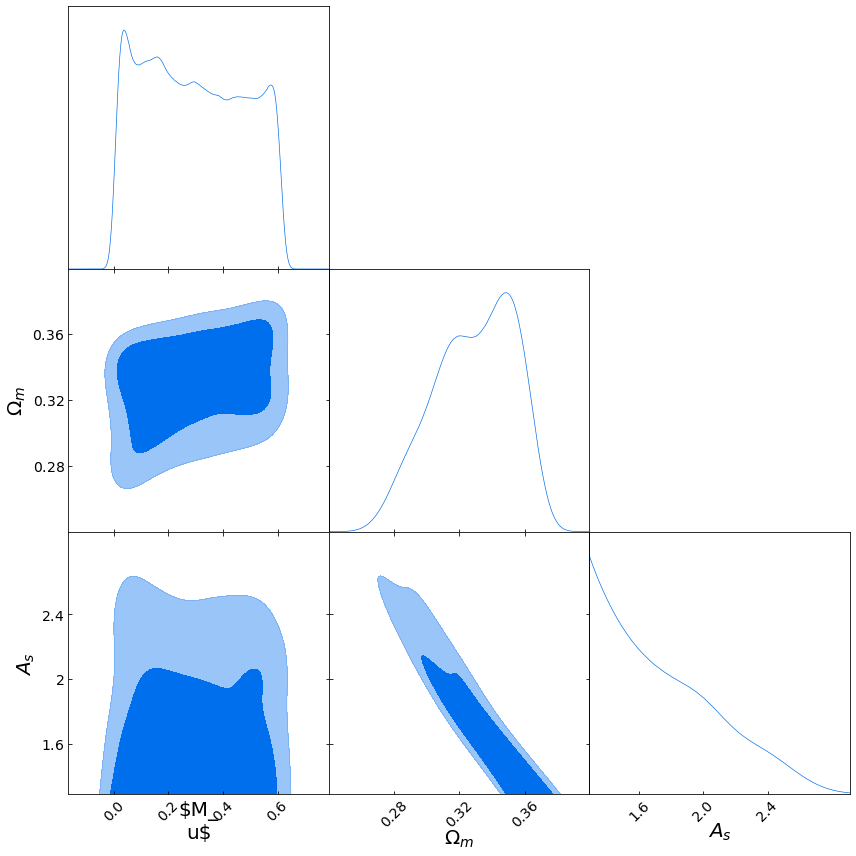

In [42]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples])